### Creating and EDF reader object using the raw PSG plus separated annotation files for sleep stages, sleep spindles and K-complexes.

In [6]:
import os

# !pip install git+https://github.com/christian-oreilly/spyndle.git
from spyndle.io import EDFReader

massPath = "/home/oreilly/MASS"

# Contains the raw signals
psg = os.path.join(massPath, "01-02-0002 PSG.edf")

annotationFileNames = [
    "01-02-0001 Base.edf",           # Sleep stage annotations
    "01-02-0001 KComplexesE1.edf",  # K-complex annotations from first expert
    "01-02-0001 SpindleE1.edf",     # Spindle annotations from first expert
    "01-02-0001 SpindleE2.edf"      # Spindle annotations from second expert
]

annotations = [os.path.join(massPath, fileName) for fileName in annotationFileNames]

reader = EDFReader(fileName=psg, 
                   annotationFileName=annotations)

Checking that events have been load properly:

In [20]:
print(reader.events)

The list object contains 5324 members:
Sleep stage 1:77
Sleep stage 2:745
Sleep stage 3:105
Sleep stage 4:170
Sleep stage ?:33
Sleep stage R:242
Sleep stage W:47
kComplexE1:409
spindleE1:1044
spindleE2:2452



In [57]:
print(type(reader.events[200]))
print(reader.events[200])

<class 'spyndle.io.edf.EDFEvent'>
groups:Stage channel: name:Sleep stage 4 startTime:2160.76076 duration:19.998720000000002 properties:{}


Listing available channels:

In [25]:
reader.getChannelLabels()

['Resp nasal',
 'EEG T4-CLE',
 'EEG P3-CLE',
 'EOG Left Horiz',
 'EEG F4-CLE',
 'EOG Right Horiz',
 'ECG I',
 'EEG T6-CLE',
 'EEG Cz-CLE',
 'EEG T5-CLE',
 'EEG F7-CLE',
 'EOG Upper Vertic',
 'EEG T3-CLE',
 'EEG C3-CLE',
 'EEG Fp2-CLE',
 'EEG O1-CLE',
 'EEG Pz-CLE',
 'EEG O2-CLE',
 'EEG Fp1-CLE',
 'EEG P4-CLE',
 'EMG Chin',
 'EEG Fpz-CLE',
 'EEG F3-CLE',
 'EEG C4-CLE',
 'EEG A2-CLE',
 'EEG F8-CLE',
 'EOG Lower Vertic']

Reading the signals for channel C3 and C4 for the duration of one scoring epochs (~20 s). 

In [31]:
startTime = reader.events[200].startTime
duration = reader.events[200].duration()
signals = reader.read(['EEG C3-CLE', 'EEG C4-CLE'], startTime, duration)
signals

{'EEG C3-CLE': <spyndle.io.EEGDatabaseReader.RecordedChannel at 0x7f56caa66fd0>,
 'EEG C4-CLE': <spyndle.io.EEGDatabaseReader.RecordedChannel at 0x7f56caa66080>}

In [58]:
print(signals['EEG C3-CLE'])

signal:[-14.4251804  -14.16849982 -13.66315994 ...,   7.45683877   4.97826695
   3.70288534], samplingRate:256.0163850486431, type:None, startTime:2160.764046


Plotting the signal for C3

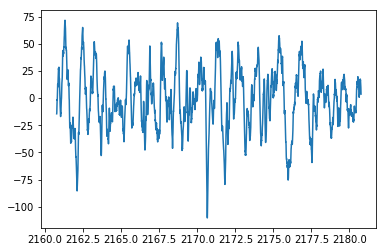

In [39]:
import matplotlib.pylab as plt 
import numpy as np
%matplotlib inline

time = np.arange(len(signals['EEG C3-CLE'].signal))/signals['EEG C3-CLE'].samplingRate + signals['EEG C3-CLE'].startTime
plt.plot(time, signals['EEG C3-CLE'].signal)

Are there any other events during the time window?

In [60]:
[e for e in reader.events if e.startTime > startTime and e.startTime < startTime + duration]

[]

No! No spindles or K-complex have been annotated during the epoch.

### Signal From whole channels can also be loaded at one like this:

In [44]:
channelSignal = reader.readChannel('EEG C3-CLE')
print(channelSignal)

signal:[  3.93654430e+01   3.62612122e+01   4.11541857e+01 ...,  -2.94048981e-03
  -2.94048981e-03  -2.94048981e-03], samplingRate:256.0163850486431, type:EEG, startTime:2000-01-01 22:35:58


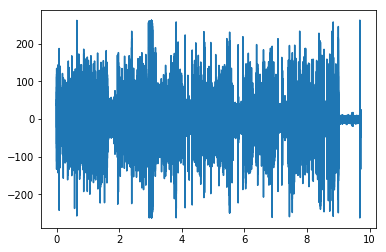

In [48]:
time = np.arange(len(channelSignal.signal))/channelSignal.samplingRate/3600
plt.plot(time, channelSignal.signal)

EDF files are splitted internally in records which are read iteratively. Only requested epochs are loaded in memory. That is, we are "streaming" the file. This is a kind of "lazy loading". The whole file is not loaded at one in memory to avoid memory issues with large files.